# Deep Neural Network (DNN)

## Data Preparation

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)

2.16.1


In [3]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/metro_interstate_traffic_volume_preprocessed.csv", parse_dates=[0])
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

# feature engineering
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)
day = 24 * 60 * 60                     
 
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values   
df = df.drop(['date_time'], axis=1)

# train-test split
n = len(df)
 
# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]               
val_df = df[int(n*0.7):int(n*0.9)]        
test_df = df[int(n*0.9):] 

scaler = MinMaxScaler()
scaler.fit(train_df)       
 
train_df.loc[:, train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df.loc[:,val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df.loc[:,test_df.columns] = scaler.transform(test_df[test_df.columns])

In [4]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 batch_size=32,
                 label_columns=None):
        
        self.train_df = train_df # contains both X & y
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        
        self.label_columns = label_columns # name of target (label) column to predict
        if label_columns is not None:
            # Create a dictionary with the name and index of the label column. 
            # This will be used for plotting
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        # Create a dictionary with the name and index of each column. 
        # This will be used to separate the features from the target variable.
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Define: input width, label width, and shift of the data window
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        # Define total window size of the data window
        self.total_window_size = input_width + shift
        
        # The slice function returns a slice object that specifies how to slice a sequence. 
        # In this case, it says that the input slice starts at "0" and ends when we reach the "input_width".
        self.input_slice = slice(0, input_width)
        # input_indices = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        # Get the index at which the label starts. 
        # In this case, it is the total window size minus the width of the label.
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        # label_indices = [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        """This is to split the data window into input and label arrays, so that our models can make predictions based on the inputs and measure an error metric against the labels.

        Args:
            features (_type_): _description_

        Returns:
            inputs (_type_): _description_
            labels (_type_):
        """
        # Slice the window to get the inputs using the "input_slice" defined in __init__.
        inputs = features[:, self.input_slice, :]
        # Slice the window to get the labels using the "labels_slice" defined in __init__.
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            # If we have more than one target, we stack the labels.
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        # The shape will be [batch, time, features]. 
        # At this point, we only specify the "time" dimension and allow the "batch" and "feature" dimensions to be defined later.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
        
    def make_dataset(self, data):
        """format the dataset into tensors so that they can be fed to our deep learning models

        Args:
            data (pd.Dataframe): training set, validation set, or test set.
            batch_size (int, optional): batch size. Defaults to 32.

        Returns:
            _type_: _description_
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None, # targets=None, as they are handled by the "split_to_input_labels" function.
            sequence_length=self.total_window_size, # the total window length.
            sequence_stride=1, # the number of timesteps separating each sequence.
            shuffle=True,
            batch_size=self.batch_size # Define the number of sequences in a single batch.
        )
        # This is used to apply the split_to_inputs_labels method to each element of the dataset ds. 
        # This method processes each time series window (a sequence of data points) to extract the input features and corresponding labels
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        # to apply the "make_dataset" function on the training dataset
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        # create a sample batch that we’ll cache within the class for plotting purposes.

        # checks if there is already a cached sample batch stored in the instance attribute "_sample_batch". 
        # If "_sample_batch" exists, it is assigned to result. 
        # If not, result is set to None
        result = getattr(self, '_sample_batch', None)
        if result is None:
            # If the sample batch does not exist, we’ll retrieve a sample batch and cache it.
            result = next(iter(self.train))
            self._sample_batch = result
        return result
        
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        """plot the input data, the predictions, and the actual values

        Args:
            model (_type_, optional): _description_. Defaults to None.
            plot_col (str, optional): _description_. Defaults to 'traffic_volume'.
            max_subplots (int, optional): _description_. Defaults to 3.
        """
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col] # identify the index of the plot_col
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            # Plot the inputs. They will appear as a continuous blue line with dots.
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            # Plot the labels or actual values. They will appear as green squares.
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                # Plot the predictions. They will appear as red crosses.
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')

## Linear Model
- A linear model is the simplest architecture we can implement in deep learning
    - Linear models have no hidden layers; the model had an input layer and an output layer.
- Use single-step model as an example:
    - A linear model simply takes all the features (temperature, cloud coverage, traffic volume, and day_sin and day_cos), calculates a weight for each of them, and sums them to output a prediction for the next timestep.
<p align="center"><img src="../../assets/img/dl-linear-model-single-step.png" width=400><br>An example of a linear model as a single-step model.</p>

- Each feature at time $t$ is assigned a weight ($w_1$ to $w_5$). They are then summed to calculate an output for the *traffic volume* at the next timestep, $t+1$
    - This is similar to a linear regression.

In [5]:
val_performance = {}
test_performance = {}

### Implementing a single-step linear model

In [6]:
train_df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.0,0.758755,0.853553,0.146447
1,0.738174,0.0,0.560765,0.750000,0.066987
2,0.698884,0.0,0.463513,0.629410,0.017037
3,0.668238,0.0,0.370029,0.500000,0.000000
4,0.643093,0.0,0.325101,0.370590,0.017037


In [7]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, 
                                train_df=train_df, val_df=val_df, test_df=test_df, 
                                batch_size=32,
                                label_columns=['traffic_volume']) 

In [27]:
def compile_and_fit(model, data_window, optimizer,
                    loss=MeanSquaredError(), 
                    metrics=[MeanAbsoluteError()],
                    patience=3, max_epochs=50):
    """This is to configure the model for training and then fits the model on the data

    Args:
        model (_type_): _description_
        data_window (_type_): _description_
        loss (_type_, optional): _description_. Defaults to MeanSquaredError().
        optimizer (_type_, optional): _description_. Defaults to Adam().
        metrics (list, optional): _description_. Defaults to [MeanAbsoluteError(), MeanAbsolutePercentageError()].
        patience (int, optional): _description_. Defaults to 3.
        max_epochs (int, optional): _description_. Defaults to 50.

    Returns:
        _type_: _description_
    """
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=loss,      # loss function
                  optimizer=optimizer,
                  metrics=metrics # evaluation metrics
    )
    
    history = model.fit(data_window.train,
                       epochs=max_epochs,
                       validation_data=data_window.val,
                       callbacks=[early_stopping])
    
    return history

In [22]:
linear_model = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear_model, single_step_window, optimizer=Adam())
 
val_performance['SS_Linear'] = linear_model.evaluate(single_step_window.val)
test_performance['SS_Linear'] = linear_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1950 - mean_absolute_error: 0.3373 - val_loss: 0.1101 - val_mean_absolute_error: 0.2556
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.0888 - mean_absolute_error: 0.2269 - val_loss: 0.0535 - val_mean_absolute_error: 0.1763
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.0443 - mean_absolute_error: 0.1566 - val_loss: 0.0280 - val_mean_absolute_error: 0.1263
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0241 - mean_absolute_error: 0.1146 - val_loss: 0.0171 - val_mean_absolute_error: 0.0946
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0157 - mean_absolute_error: 0.0917 - val_loss: 0.0126 - val_mean_absolute_error: 0.0787
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0122 - mean_absolute_error: 0.0802 - val_loss: 0.0107 - val_mean_absolute_error: 0.0721
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.0107 - mean_absolute_error

In [23]:
print(f"MAE of Single-Step Linear Model: {test_performance['SS_Linear'][1]}")

MAE of Single-Step Linear Model: 0.06309386342763901


### Implementing a multi-step linear model
- Multi-step linear model: to predict the next 24 hours of data using an input window of 24 hours of data. 

<p align="center"><img src="../../assets/img/dl-multi-step-linear-model.png" width=600><br>The multi-step linear model.</p>

In [24]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [30]:
# initialize the weights to 0, which makes the training procedure slightly faster. 
ms_linear_model = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear_model, multi_window, optimizer=Adam())

val_performance['MS_Linear'] = ms_linear_model.evaluate(multi_window.val)
test_performance['MS_Linear'] = ms_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1252 - mean_absolute_error: 0.2098 - val_loss: 0.0346 - val_mean_absolute_error: 0.1515
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0286 - mean_absolute_error: 0.1358 - val_loss: 0.0240 - val_mean_absolute_error: 0.1217
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0203 - mean_absolute_error: 0.1100 - val_loss: 0.0200 - val_mean_absolute_error: 0.1058
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0176 - mean_absolute_error: 0.0982 - val_loss: 0.0189 - val_mean_absolute_error: 0.0985
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.0168 - mean_absolute_error: 0.0932 - val_loss: 0.0185 - val_mean_absolute_error: 0.0952
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0165 - mean_absolute_error: 0.0905 - val_loss: 0.0183 - val_mean_absolute_error: 0.0932
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0163 - mean_absolute_error

In [29]:
print(f"MAE of Multi-Step Linear Model: {test_performance['MS_Linear'][1]}")

MAE of Multi-Step Linear Model: 0.07758071273565292


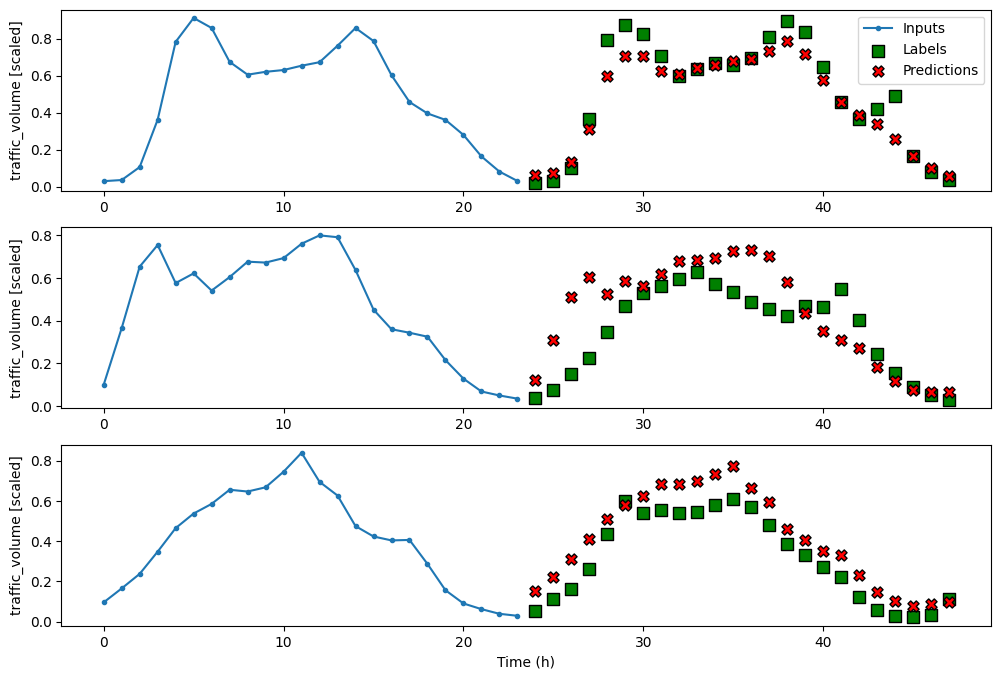

In [31]:
multi_window.plot(model=ms_linear_model)

### Implementing a multi-output linear model
- The multi-output linear model will return predictions for the traffic volume and the temperature. The input is the present timestep, and the predictions are for the next timestep.

<p align="center"><img src="../../assets/img/dl-multi-output-linear-model.png" width=400><br>The multi-output linear model.</p>

In [33]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 

In [36]:
mo_linear_model = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear_model, mo_single_step_window, optimizer=Adam())

val_performance['MO_Linear'] = mo_linear_model.evaluate(mo_single_step_window.val)
test_performance['MO_Linear'] = mo_linear_model.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3001 - mean_absolute_error: 0.3256 - val_loss: 0.0800 - val_mean_absolute_error: 0.2280
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.0592 - mean_absolute_error: 0.1930 - val_loss: 0.0371 - val_mean_absolute_error: 0.1540
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0291 - mean_absolute_error: 0.1347 - val_loss: 0.0215 - val_mean_absolute_error: 0.1143
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0180 - mean_absolute_error: 0.1030 - val_loss: 0.0149 - val_mean_absolute_error: 0.0915
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0132 - mean_absolute_error: 0.0851 - val_loss: 0.0114 - val_mean_absolute_error: 0.0776
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.0104 - mean_absolute_error: 0.0736 - val_loss: 0.0091 - val_mean_absolute_error: 0.0687
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.0086 - mean_absolute_error

In [37]:
print(f"MAE of Multi-Output Linear Model: {test_performance['MO_Linear'][1]}")

MAE of Multi-Output Linear Model: 0.0380750447511673


## Deep Neural Network (DNN) Model
- In the linear model, the input layer is directly connected to an output layer that returns a prediction. 
    - Therefore, only a linear relationship is derived. 
- In a deep neural network (DNN), we’ll add more layers between the input and output layers, called *hidden layers*. 
    - These layers allow it to model nonlinear relationships between inputs and predictions, generally resulting in better models.

<p align="center"><img src="../../assets/img/dl-linear-vs-dnn-architecture.png" width=700><br>Comparing a linear model to a deep neural network. </p>


### Implementing a deep neural network as a single-step model

In [38]:
dense_model = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense_model, single_step_window, optimizer=Adam())

val_performance['SS_Dense'] = dense_model.evaluate(single_step_window.val)
test_performance['SS_Dense'] = dense_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0448 - mean_absolute_error: 0.0924 - val_loss: 0.0050 - val_mean_absolute_error: 0.0508
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.0047 - mean_absolute_error: 0.0509 - val_loss: 0.0032 - val_mean_absolute_error: 0.0423
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0036 - mean_absolute_error: 0.0442 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0031 - mean_absolute_error: 0.0404 - val_loss: 0.0025 - val_mean_absolute_error: 0.0383
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.0029 - mean_absolute_error: 0.0390 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0026 - mean_absolute_error: 0.0368 - val_loss: 0.0025 - val_mean_absolute_error: 0.0395
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0025 - mean_absolute_error

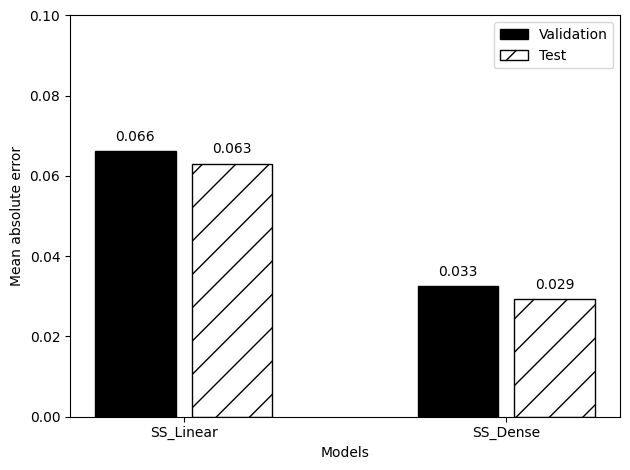

In [44]:
def plot_performance_metrics(val_performance, test_performance, model_type):
    mae_val = [v[1] for k,v in val_performance.items() if k.startswith(model_type)]
    mae_test = [v[1] for k,v in test_performance.items() if k.startswith(model_type)]

    x = np.arange(len(mae_val))

    fig, ax = plt.subplots()
    ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
    ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
    ax.set_ylabel('Mean absolute error')
    ax.set_xlabel('Models')

    for index, value in enumerate(mae_val):
        plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
        
    for index, value in enumerate(mae_test):
        plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

    plt.ylim(0, 0.1)
    plt.xticks(ticks=x, labels=[k for k in val_performance.keys() if k.startswith(model_type)])
    plt.legend(loc='best')
    plt.tight_layout()
plot_performance_metrics(val_performance, test_performance, "SS")

- Deep neural network having the best performance (lowest MAE)

### Implementing a deep neural network as a multi-step model

In [43]:
ms_dense_model = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense_model, multi_window, optimizer=Adam())
 
val_performance['MS_Dense'] = ms_dense_model.evaluate(multi_window.val)
test_performance['MS_Dense'] = ms_dense_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0649 - mean_absolute_error: 0.1145 - val_loss: 0.0157 - val_mean_absolute_error: 0.0831
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0139 - mean_absolute_error: 0.0784 - val_loss: 0.0162 - val_mean_absolute_error: 0.0839
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135 - mean_absolute_error: 0.0779 - val_loss: 0.0145 - val_mean_absolute_error: 0.0803
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131 - mean_absolute_error: 0.0767 - val_loss: 0.0144 - val_mean_absolute_error: 0.0813
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129 - mean_absolute_error: 0.0764 - val_loss: 0.0141 - val_mean_absolute_error: 0.0792
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0758 - val_loss: 0.0140 - val_mean_absolute_error: 0.0773
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127 - mean_absolute_error: 0.0754 - v

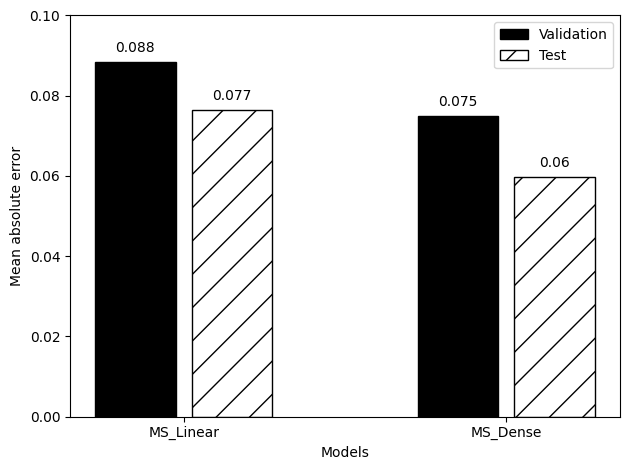

In [45]:
plot_performance_metrics(val_performance, test_performance, "MS")

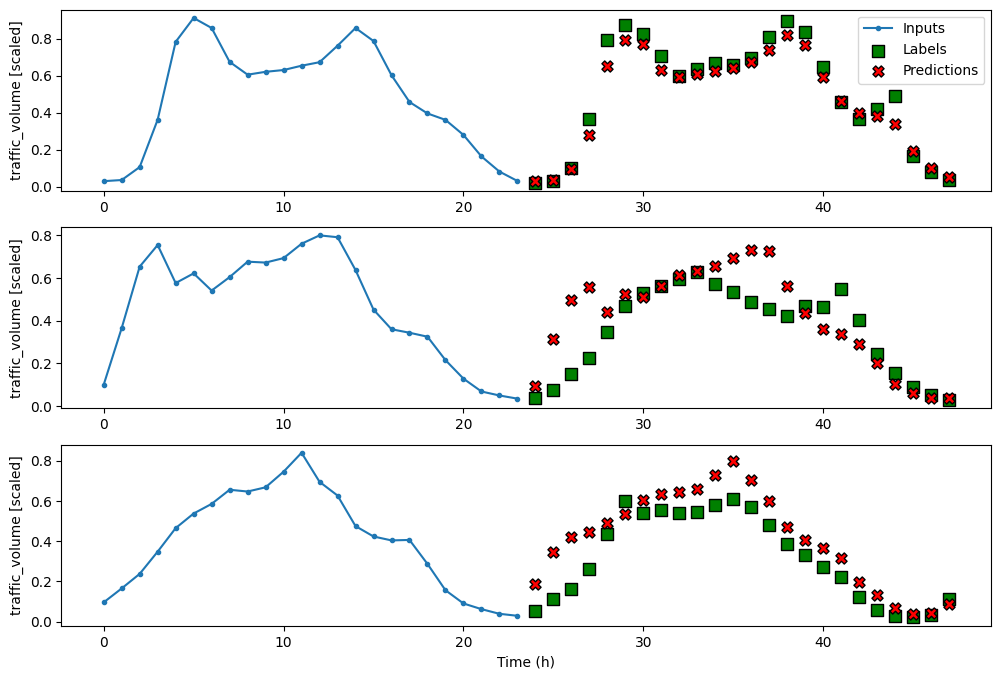

In [46]:
multi_window.plot(model=ms_dense_model)

### Implementing a deep neural network as a multi-output model

In [48]:
mo_dense_model = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2) # output is 2
])

history = compile_and_fit(mo_dense_model, mo_single_step_window, optimizer=Adam())

val_performance['MO_Dense'] = mo_dense_model.evaluate(mo_single_step_window.val)
test_performance['MO_Dense'] = mo_dense_model.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0441 - mean_absolute_error: 0.0907 - val_loss: 0.0031 - val_mean_absolute_error: 0.0362
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.0032 - mean_absolute_error: 0.0344 - val_loss: 0.0021 - val_mean_absolute_error: 0.0288
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0025 - mean_absolute_error: 0.0308 - val_loss: 0.0021 - val_mean_absolute_error: 0.0313
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.0021 - mean_absolute_error: 0.0281 - val_loss: 0.0016 - val_mean_absolute_error: 0.0263
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mean_absolute_error: 0.0271 - val_loss: 0.0015 - val_mean_absolute_error: 0.0247
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0018 - mean_absolute_error: 0.0261 - val_loss: 0.0013 - val_mean_absolute_error: 0.0231
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0017 - mean_absolute_error: 

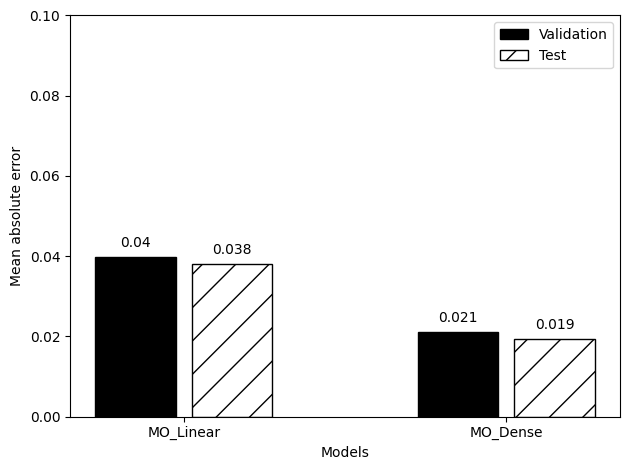

In [49]:
plot_performance_metrics(val_performance, test_performance, "MO")